In [1]:
import os
import pandas as pd
import tensorflow as tf
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.optimizers import Adam
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.utils.class_weight import compute_class_weight
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Dropout, Bidirectional, Conv1D, GlobalMaxPooling1D, Concatenate, AdditiveAttention
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import AdditiveAttention
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from utils import eval, eval_training, get_train_test_data, save_for_evaluation, process_train_test_data
import re
import numpy as np
import spacy
from gensim.models import Word2Vec
from transformers import BertTokenizer, TFBertModel


os.environ['TF_NUM_INTEROP_THREADS'] = '10'
os.environ['TF_NUM_INTRAOP_THREADS'] = '10'

# Configure TensorFlow session for multi-threading
tf.config.threading.set_inter_op_parallelism_threads(10)
tf.config.threading.set_intra_op_parallelism_threads(10)
# Ensure TensorFlow is using the Metal backend
gpu = len (tf.config.list_physical_devices ('GPU'))>0
print ("GPU is", "available" if gpu else "NOT AVAILABLE")

GPU is available


In [2]:
unique_types = {type(v) for v in df_test['data'].dropna().unique()}
print(unique_types)


NameError: name 'df_test' is not defined

# Data preparation

In [7]:
data_label = "data"
predict_label = "label"
balanced = False
labels = None
class_weights = False
sample_weights = False
df_train = pd.read_csv('../data/data_train.csv')
df_valid = pd.read_csv('../data/data_valid.csv')
df_test = pd.read_csv('../data/data_test.csv')

train_texts = df_train[data_label].astype(str)
valid_texts = df_valid[data_label].astype(str)
test_texts = df_test[data_label].astype(str)

all_labels = pd.concat([df_train[predict_label], df_valid[predict_label], df_test[predict_label]])
label_encoder = LabelEncoder()
label_encoder.fit(all_labels)
# Fit label encoder and return encoded labels as integers
train_labels_enc = label_encoder.transform(df_train[predict_label])
valid_labels_enc = label_encoder.transform(df_valid[predict_label])
test_labels_enc = label_encoder.transform(df_test[predict_label])

# Convert labels to categorical one-hot encoding
train_labels = to_categorical(train_labels_enc)
valid_labels = to_categorical(valid_labels_enc)
test_labels = to_categorical(test_labels_enc)

num_classes = len(df_train[predict_label].unique())

In [5]:
from transformers import BertTokenizer, BertModel
import torch
import concurrent.futures
import pickle
import numpy as np

# Function to generate word embeddings for a given batch of texts
def generate_bert_embeddings_batch(texts, tokenizer, model, max_length):
    inputs = tokenizer(texts, truncation=True, padding='max_length', max_length=max_length, return_tensors='pt')
    with torch.no_grad():
        outputs = model(**inputs)
    embeddings = outputs.last_hidden_state
    return embeddings.numpy()

model_name = "GerMedBERT/medbert-512"
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertModel.from_pretrained(model_name)

# Function to generate embeddings concurrently in batches
def generate_embeddings_concurrently(texts, tokenizer, model, max_length, batch_size=32):
    embeddings = []
    with concurrent.futures.ThreadPoolExecutor() as executor:
        futures = []
        for i in range(0, len(texts), batch_size):
            batch_texts = texts[i:i+batch_size]
            futures.append(executor.submit(generate_bert_embeddings_batch, batch_texts, tokenizer, model, max_length))
        
        for future in concurrent.futures.as_completed(futures):
            try:
                batch_embeddings = future.result()
                embeddings.extend(batch_embeddings)
            except Exception as exc:
                print(f'Generated an exception: {exc}')
    return np.array(embeddings)

# Ensure texts are in list format
train_texts = train_texts.tolist()
valid_texts = valid_texts.tolist()
test_texts = test_texts.tolist()

# Define the max length for padding
max_length = 400  # or set to a specific value based on your data
print("Starting")



bert_valid_embeddings = generate_embeddings_concurrently(valid_texts, tokenizer, model, max_length)
bert_padded_valid_embeddings = np.pad(bert_valid_embeddings, ((0,0),(0,max_length-bert_valid_embeddings.shape[1]),(0,0)), 'constant')
with open('bert_valid.pkl', 'wb') as file:
    pickle.dump(bert_padded_valid_embeddings, file)
print("Valid done")

print("Starting")
bert_test_embeddings = generate_embeddings_concurrently(test_texts, tokenizer, model, max_length)
bert_padded_test_embeddings = np.pad(bert_test_embeddings, ((0,0),(0,max_length-bert_test_embeddings.shape[1]),(0,0)), 'constant')
with open('bert_test.pkl', 'wb') as file:
    pickle.dump(bert_padded_test_embeddings, file)
print("Test done")

Some weights of BertModel were not initialized from the model checkpoint at GerMedBERT/medbert-512 and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Starting


: 

In [3]:
from transformers import BertTokenizer, BertModel
import torch
import concurrent.futures
import pickle
import numpy as np

# Function to generate word embeddings for a given batch of texts
def generate_bert_embeddings_batch(texts, tokenizer, model, max_length):
    inputs = tokenizer(texts, truncation=True, padding='max_length', max_length=max_length, return_tensors='pt')
    with torch.no_grad():
        outputs = model(**inputs)
    embeddings = outputs.last_hidden_state
    return embeddings.numpy()

model_name = "GerMedBERT/medbert-512"
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertModel.from_pretrained(model_name)

# Function to generate embeddings concurrently in batches
def generate_embeddings_concurrently(texts, tokenizer, model, max_length, batch_size=32):
    embeddings = []
    with concurrent.futures.ThreadPoolExecutor() as executor:
        futures = []
        for i in range(0, len(texts), batch_size):
            batch_texts = texts[i:i+batch_size]
            futures.append(executor.submit(generate_bert_embeddings_batch, batch_texts, tokenizer, model, max_length))
        
        for future in concurrent.futures.as_completed(futures):
            try:
                batch_embeddings = future.result()
                embeddings.extend(batch_embeddings)
            except Exception as exc:
                print(f'Generated an exception: {exc}')
    return np.array(embeddings)

# Ensure texts are in list format
train_texts = train_texts.tolist()
valid_texts = valid_texts.tolist()
test_texts = test_texts.tolist()

# Define the max length for padding
max_length = 400  # or set to a specific value based on your data
# Generate embeddings concurrently in batches
bert_train_embeddings = generate_embeddings_concurrently(train_texts, tokenizer, model, max_length)
bert_padded_train_embeddings = np.pad(bert_train_embeddings, ((0,0),(0,max_length-bert_train_embeddings.shape[1]),(0,0)), 'constant')
# Save padded embeddings to files
with open('bert_train.pkl', 'wb') as file:
    pickle.dump(bert_padded_train_embeddings, file)
print("Training done")


Some weights of BertModel were not initialized from the model checkpoint at GerMedBERT/medbert-512 and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training done


In [17]:
print(len(bert_padded_train_embeddings))
print(len(train_labels))
bert_padded_test_embeddings[1]

23524
23524


array([[ 0.4579936 , -0.42572418, -0.01689238, ...,  0.27999812,
        -0.8707264 , -0.28893712],
       [ 0.31118962,  0.58352566, -0.5810889 , ..., -0.18389681,
         0.089366  ,  0.32738617],
       [-1.0408983 , -1.2821083 , -0.7190773 , ...,  1.3408915 ,
         1.3595942 , -0.9685643 ],
       ...,
       [ 0.2446376 ,  0.6225694 ,  0.7972241 , ...,  0.23370731,
        -0.26543692, -0.48909345],
       [ 0.19779879,  0.56298476,  0.831251  , ...,  0.26996705,
        -0.22858366, -0.44749984],
       [ 0.30622005,  0.4650764 ,  0.8175808 , ...,  0.26954547,
        -0.24950328, -0.49454236]], dtype=float32)

In [8]:
import pickle
with open("bert_train.pkl", "rb") as input_file:
    bert_padded_train_embeddings = pickle.load(input_file)
with open("bert_valid.pkl", "rb") as input_file:
    bert_padded_valid_embeddings = pickle.load(input_file)
with open("bert_test.pkl", "rb") as input_file:
    bert_padded_test_embeddings = pickle.load(input_file)

# Model parameters

In [9]:
embedding_dim = bert_padded_train_embeddings.shape[-1]
max_length = 400
model_name = "bert"

In [10]:
from utils import get_standard_parameters

optimizer, loss, metrics, early_stopping_callback, _, lstm_units, epochs, batch_size = get_standard_parameters()

# Model definition and training

In [11]:
# Define the input layers
input_text = Input(shape=(max_length, embedding_dim), dtype='float32', name='text_input')

# Two LSTM layers
x = Bidirectional(LSTM(units=lstm_units, return_sequences=True))(input_text)
x = Dropout(0.5)(x)
x = Bidirectional(LSTM(units=lstm_units))(x)

# Output layer
output = Dense(num_classes, activation='softmax')(x)

# Define the model
model = Model(inputs=input_text, outputs=output)

# Compile the model
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [12]:
history = model.fit(bert_padded_train_embeddings, train_labels, epochs=epochs, batch_size=batch_size,
                    validation_data=(bert_padded_valid_embeddings, valid_labels), callbacks=[])

Epoch 1/15


2024-07-27 09:01:54.351644: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


736/736 ━━━━━━━━━━━━━━━━━━━━ 182s 244ms/step - accuracy: 0.3986 - auc: 0.7721 - f1_score: 0.1799 - loss: 1.2525 - val_accuracy: 0.3764 - val_auc: 0.7462 - val_f1_score: 0.1214 - val_loss: 1.3264
Epoch 2/15
736/736 ━━━━━━━━━━━━━━━━━━━━ 276s 376ms/step - accuracy: 0.4126 - auc: 0.7808 - f1_score: 0.1645 - loss: 1.2190 - val_accuracy: 0.3772 - val_auc: 0.7415 - val_f1_score: 0.1200 - val_loss: 1.3612
Epoch 3/15
736/736 ━━━━━━━━━━━━━━━━━━━━ 149s 202ms/step - accuracy: 0.4216 - auc: 0.7843 - f1_score: 0.1700 - loss: 1.2112 - val_accuracy: 0.3753 - val_auc: 0.7334 - val_f1_score: 0.1194 - val_loss: 1.3767
Epoch 4/15
736/736 ━━━━━━━━━━━━━━━━━━━━ 153s 207ms/step - accuracy: 0.4156 - auc: 0.7822 - f1_score: 0.1605 - loss: 1.2119 - val_accuracy: 0.3762 - val_auc: 0.7300 - val_f1_score: 0.1186 - val_loss: 1.3810
Epoch 5/15
736/736 ━━━━━━━━━━━━━━━━━━━━ 153s 207ms/step - accuracy: 0.4091 - auc: 0.7780 - f1_score: 0.1614 - loss: 1.2230 - val_accuracy: 0.3771 - val_auc: 0.7245 - val_f1_score: 0.1176 

In [13]:
save_for_evaluation(model, history, model_name, bert_padded_test_embeddings, test_labels, label_encoder)

Model saved to ../models/lstm/bert/bert.h5
Data saved


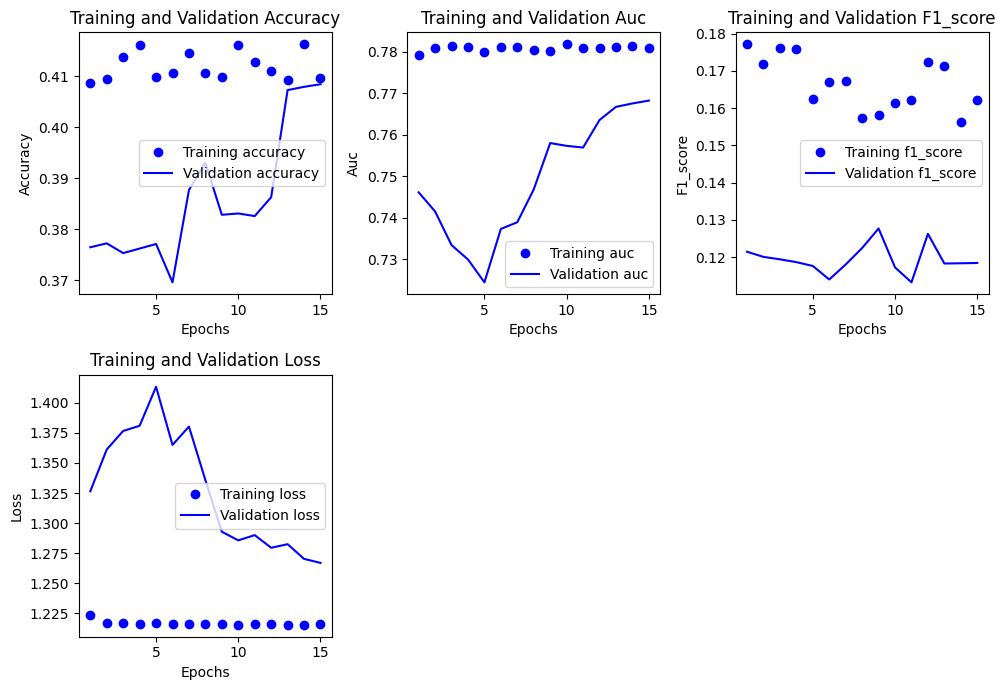

In [14]:
eval_training(history, metrics)

In [15]:
eval(model, test_padded, test_labels, label_encoder)

NameError: name 'test_padded' is not defined